<a href="https://colab.research.google.com/github/jjhwan-h/ML/blob/main/ML_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
#데이터 읽기 및 분리
data=pd.read_csv('/content/shopping_data.csv')

X=data.drop('Revenue',axis=1)
y=data['Revenue']
data['Revenue'].value_counts() # False:10422, True:1908

Revenue
False    10422
True      1908
Name: count, dtype: int64

In [ ]:
label_encoder = LabelEncoder()

#Month 라벨인코딩
encoded_clases = label_encoder.fit_transform(X['Month'])
X['Month']=encoded_clases
#VisitorType 라벨인코딩
encoded_clases = label_encoder.fit_transform(X['VisitorType'])
X['VisitorType']=encoded_clases
#Weekend 라벨인코딩
encoded_clases = label_encoder.fit_transform(X['Weekend'])
X['Weekend']=encoded_clases
#Revenue 라벨인코딩
encoded_clases = label_encoder.fit_transform(y)
y=pd.Series(encoded_clases)
print(X)
print(y)

In [5]:
#SMOTE
new_X, new_y = SMOTE(sampling_strategy=1,random_state =10).fit_resample(X, y)
new_y.value_counts()

0    10422
1    10422
Name: count, dtype: int64

In [86]:
#train, test, valid 세트 나누기
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.3, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=12)

In [ ]:
# 다양한 하이퍼파라미터 설정으로 여러 XGBoost모델 생성
model1 = xgb.XGBClassifier(learning_rate=0.3, n_estimators=200, max_depth=3, reg_lambda=0.2)
model2 = xgb.XGBClassifier(learning_rate=0.3, n_estimators=300, max_depth=5, reg_lambda=0.2)
model3 = xgb.XGBClassifier(learning_rate=0.3 ,n_estimators=400, max_depth=7, reg_lambda=0.2)

# 각 모델에 조기 종료를 설정하고 학습
for model in [model1, model2, model3]:
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)])

# 앙상블 모델 생성 (soft voting방식 => 개별 모델들의 예측 결과의 확률값을 평균하여 최종 결과를 예측)
ensemble_model = VotingClassifier(estimators=[('model1', model1), ('model2', model2), ('model3', model3)], voting='soft')
ensemble_model.fit(X_train,y_train)

In [88]:
y_pred = ensemble_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("정확도:",accuracy)

정확도: 0.9360409338023665


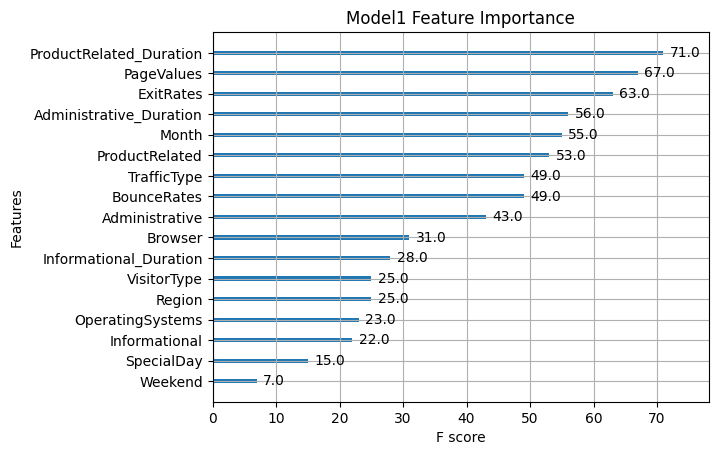

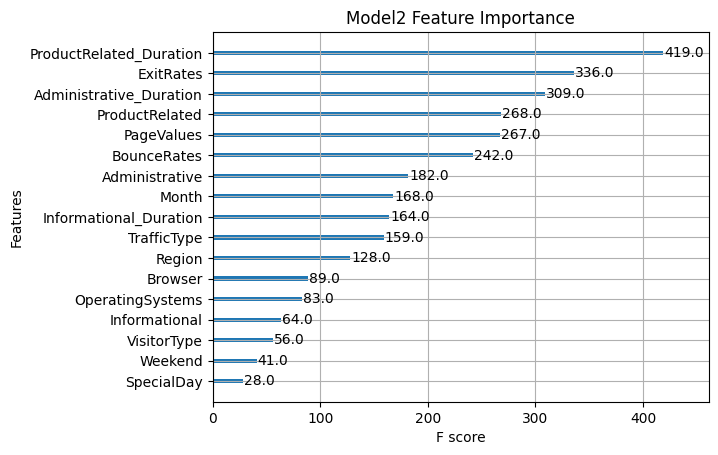

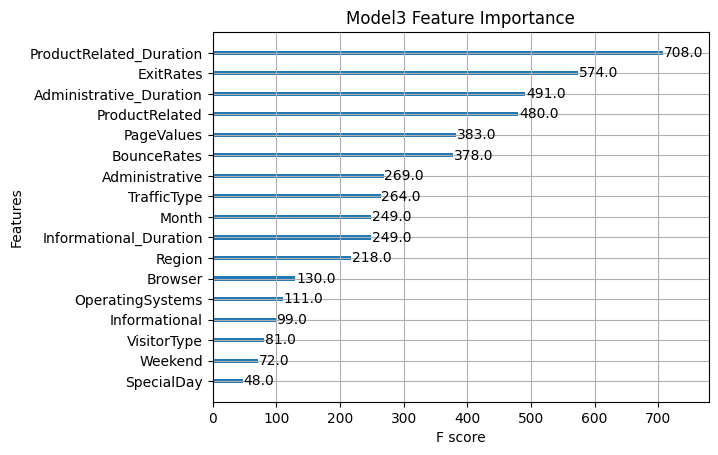

In [12]:
#특성 중요도 시각화
xgb.plot_importance(model1)
plt.title("Model1 Feature Importance")
xgb.plot_importance(model2)
plt.title("Model2 Feature Importance")
xgb.plot_importance(model3)
plt.title("Model3 Feature Importance")
plt.show()